# Design Under Uncertainty

*Purpose*: 


## Setup


In [1]:
import grama as gr
DF = gr.Intention()
%matplotlib inline

# Uncertainty Propagation


In [2]:
from grama.models import make_prlc_rand
md_circuit = make_prlc_rand()


## Perturbed Design Variables

(Manufacturing variability means real parts will tend to be slightly different from designed parts.)


In the previous exercise e-grama07-fit-multivar we saw a model for a circuit's performance. That system exhibited variability in its *realized component values*; we could pick the nominal (designed) component values `R, L, C`, but manufacturing variability would give rise to different as-made component values `Rr, Lr, Cr`.

As a reminder, let's take a look at designed `C` and realized `Cr` values of the circuit capacitance.


In [3]:
# NOTE: No need to edit; run and inspect
(
    md_circuit
    >> gr.ev_sample(n=1e3, df_det="nom")
    
    >> gr.tf_summarize(
        C=gr.mean(DF.C),
        Cr_lo=gr.quant(DF.Cr, p=0.05),
        Cr_mu=gr.mean(DF.Cr),
        Cr_up=gr.quant(DF.Cr, p=0.95),
    )
)

eval_sample() is rounding n...


,C,Cr_lo,Cr_mu,Cr_up
0,50.0005,42.465673,65.400415,87.142057


### __qX__ Interpret the following density plot

The nominal value for `Design 1` is `x = 0.5`, while the nominal value for `Design 2` is `x = 1.5`. However, parts manufactured according to both designs are subject to manufacturing variability, as depicted by the following densities. Answer the questions under *observations* below.


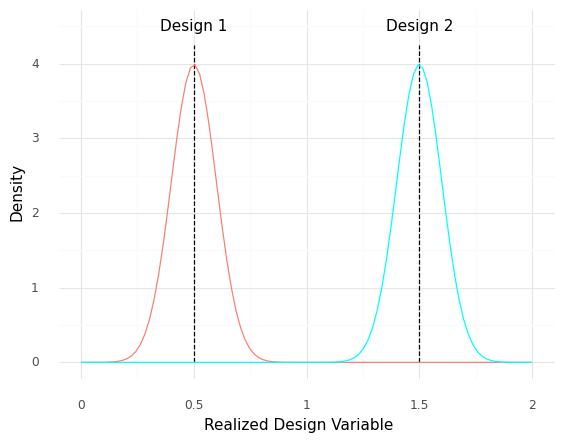

<ggplot: (8785511871386)>

In [4]:
mg_1 = gr.marg_mom("norm", mean=+0.5, sd=0.1)
mg_2 = gr.marg_mom("norm", mean=+1.5, sd=0.1)

(
    gr.df_make(x=gr.linspace(0, +2, 100))
    >> gr.tf_mutate(
        y_1=mg_1.d(DF.x),
        y_2=mg_2.d(DF.x),
    )
    
    >> gr.ggplot(gr.aes("x"))
    + gr.annotate("segment", x=+0.5, xend=+0.5, y=0, yend=4.25, linetype="dashed")
    + gr.annotate(
        "text",
        x=+0.5, y=4.5,
        label="Design 1",
    )
    + gr.annotate("segment", x=+1.5, xend=+1.5, y=0, yend=4.25, linetype="dashed")
    + gr.annotate(
        "text",
        x=+1.5, y=4.5,
        label="Design 2",
    )
    + gr.geom_line(gr.aes(y="y_1"), color="salmon")
    + gr.geom_line(gr.aes(y="y_2"), color="cyan")
    
    + gr.theme_minimal()
    + gr.labs(
        x="Realized Design Variable",
        y="Density"
    )
)

*Observations*

For the following questions, assume that you can measure `x` with *perfect* accuracy.

<!-- task-begin -->
- Suppose you have a part with `x == 0.61`. Which design specification was this most likely manufactured according to?
  - (Your response here)
- Suppose you selected a random part of `Design 2` off the manufacturing line and found that `x == 1.40`. Would you be surprised by this?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Suppose you have a part with `x == 0.61`. Which design specification was this most likely manufactured according to?
  - `Design 1`
- Suppose you selected a random part of `Design 2` off the manufacturing line and found that `x == 1.40`. Would you be surprised by this?
  - Unsurprising; we can see that `x == 1.40` is well-within the distribution around the nominal `Design 2` value.
<!-- solution-end -->

### __qX__ Set up a perturbation model


## Downstream Uncertainty


### __qX__ Do a sweep with quantified uncertainty

TODO


## Real vs Error

Generally speaking: Real variability will propagate through a system without our intervention. Error will only propagate into a system through our design decisions.


TODO Illustrative example


```{admonition} Separating real and erroneous variability
Most physical scenarios will exhibit both real and erroneous variability. Only careful data collection combined with sound statistical analysis can seprate these two sources of variability.
```

# Designing for uncertainty


## Robustness


In [5]:
md_poly = (
    gr.Model("Polynomial")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            xp=df.x + df.e
        ),
        var=["x", "e"],
        out=["xp"],
        name="Additive input noise"
    )
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            y=(df.xp + 0.6) 
             *(df.xp + 0.4) 
             *(df.xp - 0.65)
             *(df.xp - 0.55)
             *13.5 * (1 + gr.exp(8.0 * df.xp))
        ),
        var=["xp"],
        out=["y"],
        name="Function to minimize"
    )
    >> gr.cp_bounds(x=(-1, +1))
    >> gr.cp_marginals(e=gr.marg_mom("norm", mean=0, sd=0.03))
    >> gr.cp_copula_independence()
)

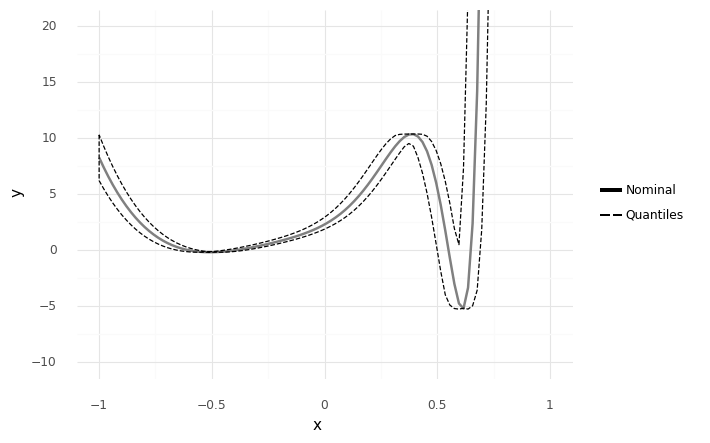

<ggplot: (8785474094620)>

In [6]:
# Evaluate model without uncertainty
df_poly_nom = (
    md_poly
    >> gr.ev_nominal(
        df_det=gr.df_make(x=gr.linspace(-1, +1, 100)),
    )
)

# Evaluate with uncertainty, take quantiles
df_poly_mc = (
    md_poly
    >> gr.ev_sample(
        df_det=gr.df_make(x=gr.linspace(-1, +1, 100)),
        n=40,
        seed=101,
    )
    >> gr.tf_group_by("x")
    >> gr.tf_summarize(
        y_lo=gr.quant(DF.y, p=0.05),
        y_mu=gr.median(DF.y),
        y_up=gr.quant(DF.y, p=0.95),
    )
    >> gr.tf_ungroup()
)

# Visualize
(
    df_poly_mc
    >> gr.tf_mutate(source="Quantiles")
    >> gr.ggplot(gr.aes("x"))
    + gr.geom_line(
        data=df_poly_nom
        >> gr.tf_mutate(source="Nominal"),
        mapping=gr.aes(y="y", linetype="source", color="source"),
        size=1,
    )
    + gr.geom_ribbon(
        mapping=gr.aes(ymin="y_lo", ymax="y_up", linetype="source", color="source"),
        fill=None,
    )
    
    + gr.scale_y_continuous(breaks=(-10, -5, 0, +5, +10, +15, +20))
    + gr.scale_linetype_discrete(name=" ")
    + gr.scale_color_manual(
        values=dict(Nominal="grey", Quantiles="black"),
    )
    + gr.coord_cartesian(ylim=(-10, 20))
    + gr.theme_minimal()
    + gr.guides(color=None)
)

*Observations*

For this example, *lower* values of `y` are better.

<!-- task-begin -->
- *Approximately*, what is the lowest value `y` value the `Nominal` curve achieves across the values of `x` depicted above?
  - (Your response here)
- *Approimately*, what is the value of `y` for the `Nominal` curve at `x = -0.5`?
  - (Your response here)
- Note the spread between the `Quantiles` at $x \approx 0.6$. *Approximately* what range of `y` values would you expect to result from releated manufacturing at $x \approx 0.6$?
  - (Your response here)
- Note the spread between the `Quantiles` at $x \approx -0.5$. *Approximately* what range of `y` values would you expect to result from releated manufacturing at $x \approx -0.5$?
  - (Your response here)
- Suppose you plan to manufacture many parts according to this process, test all specimens, and choose the 5%. Which design (value of `x`) would you pick, and why?
  - (Your response here)
- Suppose you plan to manufacture many parts according to this process, all of which must work at an acceptable level. Which design (value of `x`) would you pick, and why?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
<!-- solution-end -->

## Reliability


## Setting Variability Targets
